In [1]:
import glob
import cv2
import torch
import numpy as np
import torch.nn.functional as F

device1 = 'cuda'

import time

# Record the start time
start_time = time.time()

def rgb_to_gray_image_conversion_gpu(filelist):

    gray_image_list = []
    rgb_image_list = []

    for file in filelist:
        image_rgb = cv2.imread(file)

        # Convert to PyTorch tensor and move to GPU
        image_rgb_tensor = torch.tensor(image_rgb, device=device1).float()

        # Convert to grayscale and move to CPU
        gray_image = torch.tensor(cv2.cvtColor(image_rgb_tensor.cpu().numpy(), cv2.COLOR_BGR2GRAY))
        gray_image_list.append(gray_image)

        rgb_image_list.append(image_rgb_tensor)

    return gray_image_list, rgb_image_list






def file_to_gray(gray_image_list, index_no):
    gray_image = gray_image_list[index_no].to(device=device1, dtype=torch.float)

    # Convert to PyTorch tensor and move to GPU
    padded_gray_image = F.pad(gray_image, (1, 1, 1, 1), 'constant', 0)

    # Move back to CPU
    return padded_gray_image


year_int = 2000

filelist = glob.glob(str(year_int)+'/*.png')
filelist.sort()

print(filelist)


gray_image_list_gpu, rgb_image_list_gpu = rgb_to_gray_image_conversion_gpu(filelist)


['2000/20000901.png', '2000/20000902.png', '2000/20000903.png', '2000/20000904.png', '2000/20000905.png', '2000/20000906.png', '2000/20000907.png', '2000/20000908.png', '2000/20000909.png', '2000/20000910.png', '2000/20000911.png', '2000/20000912.png', '2000/20000913.png', '2000/20000914.png', '2000/20000915.png', '2000/20000916.png', '2000/20000917.png', '2000/20000918.png', '2000/20000919.png', '2000/20000920.png', '2000/20000921.png', '2000/20000922.png', '2000/20000923.png', '2000/20000924.png', '2000/20000925.png', '2000/20000926.png', '2000/20000927.png', '2000/20000928.png', '2000/20000929.png', '2000/20000930.png', '2000/20001001.png', '2000/20001002.png', '2000/20001003.png', '2000/20001004.png', '2000/20001005.png', '2000/20001006.png', '2000/20001007.png', '2000/20001008.png', '2000/20001009.png', '2000/20001010.png', '2000/20001011.png', '2000/20001012.png', '2000/20001013.png', '2000/20001014.png', '2000/20001015.png', '2000/20001016.png', '2000/20001017.png', '2000/200010

In [2]:
import torch
import torch.nn.functional as F

def getIndices(x, kernel_size_h, kernel_size_w, stride_h, stride_w):
    indices = {}
    stride = 2
    kernel_size = 2
    h_out = (x.size(0) - kernel_size_h) // stride_h + 1
    w_out = (x.size(1) - kernel_size_w) // stride_w + 1

    for i in range(h_out):
        for j in range(w_out):
            start_i = i * stride_h
            start_j = j * stride_w
            end_i = start_i + kernel_size_h
            end_j = start_j + kernel_size_w

            indices[(i, j)] = [
                (start_i, start_j),               # top-left
                (start_i, end_j-1),               # top-right
                (end_i-1, start_j),               # bottom-left
                (end_i-1, end_j-1)                # bottom-right
            ]

    return indices

def getIndices_in_orginal_gray(row, col, combined_indices):
    indices_list_gray_image = [index for sublist in combined_indices[(row, col)].values() for index in sublist]
    return indices_list_gray_image

def get_combined_indices_on_gpu(x, y, kernel_size_h, kernel_size_w, stride_h, stride_w):
    # Move tensors to GPU
    x_gpu = x.to(device=device1, dtype=torch.float)
    y_gpu = y.to(device=device1, dtype=torch.float)

    # Get indices on GPU
    indices1 = getIndices(x_gpu, kernel_size_h, kernel_size_w, stride_h, stride_w)
    indices2 = getIndices(y_gpu, kernel_size_h, kernel_size_w, stride_h, stride_w)

    # Move data back to CPU
    x_cpu = x_gpu.cpu()
    y_cpu = y_gpu.cpu()

    # Combine indices on CPU
    combined_indices = {}
    for key2, value2 in indices2.items():
        temp_dict = {}
        for idx in value2:
            temp_dict[idx] = indices1[idx]
        combined_indices[key2] = temp_dict

    return combined_indices

x = torch.arange(0, 332*316, dtype=torch.float).reshape(332, 316)
padded_x = F.pad(x, (1, 1, 1, 1), 'constant', 0)

# Applying average pooling
y = F.avg_pool2d(padded_x.unsqueeze(0).unsqueeze(0), kernel_size=(2, 2), stride=(2, 2)).squeeze()
y_output = F.avg_pool2d(y.unsqueeze(0).unsqueeze(0), kernel_size=(2, 2), stride=(2, 2)).squeeze()

# Get combined indices on GPU
combined_indices_gpu = get_combined_indices_on_gpu(padded_x, y, 2, 2, 2, 2)

print('indices1')
print(len(combined_indices_gpu))
print('indices2')
print(len(combined_indices_gpu))

# Example usage on GPU
print(len(getIndices_in_orginal_gray(2, 3, combined_indices_gpu)))
print(getIndices_in_orginal_gray(0, 0, combined_indices_gpu))


indices1
6557
indices2
6557
16
[(0, 0), (0, 1), (1, 0), (1, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 0), (2, 1), (3, 0), (3, 1), (2, 2), (2, 3), (3, 2), (3, 3)]


In [3]:
import pandas as pd
import numpy as np
import torch

def getKernel(input):
    # Move input data to GPU
    #input_gpu = torch.tensor(input, dtype=torch.float, device=device1).clone().detach()

    result_df = torch.ones((2, 2))
    result_df_gpu = result_df.clone().detach().to(device=device1, dtype=torch.float)

    return result_df_gpu

# Example usage
input_data = np.random.rand(83, 79)
result_on_gpu = getKernel(input_data)
print(result_on_gpu)


tensor([[1., 1.],
        [1., 1.]], device='mps:0')


In [4]:
import torch

def get_diff_gray_image_kernel_list_gpu(gray_image_list):
    diff_gray_image_list = []
    diff_gray_image_kernel_list_2_2 = []

    for i in range(len(gray_image_list)-1):
        # Move data to GPU
        arr_gpu = (torch.tensor(gray_image_list[i+1], dtype=torch.float, device=device1).clone().detach() - torch.tensor(gray_image_list[i], dtype=torch.float, device=device1).clone().detach())

        # Convert back to NumPy for further processing
        arr = arr_gpu #.cpu().numpy()
        diff_gray_image_list.append(arr)

        # Assuming getKernel is a function that also supports GPU
        kernel_arr_gpu = getKernel(arr_gpu)
        kernel_arr = kernel_arr_gpu #.clone().detach().cpu().numpy()
        diff_gray_image_kernel_list_2_2.append(kernel_arr)

    return diff_gray_image_list, diff_gray_image_kernel_list_2_2

# Example usage
gray_image_list = [np.random.rand(332, 316), np.random.rand(332, 316)]
diff_gray_image_list_gpu, diff_gray_image_kernel_list_2_2_gpu = get_diff_gray_image_kernel_list_gpu(gray_image_list)
print(diff_gray_image_list_gpu)
print(diff_gray_image_kernel_list_2_2_gpu)



[tensor([[ 0.4848,  0.2809, -0.0737,  ..., -0.5290, -0.3533,  0.4037],
        [ 0.0115,  0.2689,  0.5954,  ...,  0.2007,  0.1445, -0.5211],
        [-0.1242,  0.0409,  0.0356,  ..., -0.3830, -0.3266, -0.1927],
        ...,
        [-0.1751, -0.1526,  0.1272,  ..., -0.1837, -0.6886, -0.0293],
        [-0.1656, -0.6679,  0.7359,  ...,  0.2546, -0.1740,  0.4952],
        [-0.4231,  0.3662,  0.1167,  ...,  0.0355,  0.1182, -0.4008]],
       device='mps:0')]
[tensor([[1., 1.],
        [1., 1.]], device='mps:0')]


In [5]:
import torch
import torch.nn as nn
import numpy as np

def apply_3x3_sharpening(input_tensor, kernel):
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0).float().to(device1)
    kernel_tensor = kernel.unsqueeze(0).unsqueeze(0).float().to(device1)
    
    kernel_row, kernel_col = len(kernel_tensor), len(kernel_tensor[0])

    conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(kernel_row, kernel_col), stride=(2, 2), padding=1, bias=False).to(device1)
    conv_layer.weight.data = kernel_tensor

    output = conv_layer(input_tensor)

    return output[0, 0].detach().cpu().numpy()

def get_kernel_applied_result_in_diff_gray_image_cpu(diff_gray_image_list, diff_gray_image_kernel_list_2_2):
    kernel_applied_result_in_diff_gray_image = []

    for i in range(len(diff_gray_image_list)):
        matrix = diff_gray_image_list[i].clone().detach()
        kernel = diff_gray_image_kernel_list_2_2[i].clone().detach()

        result = apply_3x3_sharpening(matrix, kernel)
        kernel_applied_result_in_diff_gray_image.append(result)

    return kernel_applied_result_in_diff_gray_image

# Example usage
diff_gray_image_list_gpu, diff_gray_image_kernel_list_2_2_gpu = get_diff_gray_image_kernel_list_gpu(gray_image_list)
np.savetxt('kerenel_applied_diff_2-1_gpu.txt', get_kernel_applied_result_in_diff_gray_image_cpu(diff_gray_image_list_gpu, diff_gray_image_kernel_list_2_2_gpu)[0], delimiter='\t', fmt='%.4f')


In [6]:
import torch

def truncating_array_83_79_gpu(original_array):
    # Convert the NumPy array to a PyTorch tensor and move it to GPU
    original_tensor = torch.tensor(original_array).float().to(device1)

    # Define the pooling parameters
    pool_size = (2, 2)
    stride = 2

    # Calculate the dimensions of the output tensor
    output_height = (original_tensor.shape[1] - pool_size[0]) // stride + 1
    output_width = (original_tensor.shape[2] - pool_size[1]) // stride + 1

    # Initialize the output tensor on GPU
    output_tensor = torch.zeros((original_tensor.shape[0], output_height, output_width, 4), device=device1)

    # Apply 2x2 average pooling with a stride of 2
    for i in range(output_height):
        for j in range(output_width):
            # Define the pooling region
            region = original_tensor[:, i * stride:i * stride + pool_size[0], j * stride:j * stride + pool_size[1]]
            # Reshape the region to a (4,) tensor and store it in the output tensor
            output_tensor[:, i, j] = region.reshape(-1, 4)

    # Move the output tensor back to CPU and convert it to a NumPy array
    reshaped_data = output_tensor.detach().cpu().numpy()

    return reshaped_data

# Assuming device1 is defined earlier
device1 = 'cuda'



In [7]:
kernel_applied_result_in_diff_gray_image_overall = []



def get_kernel_applied_result_in_diff_gray_image_gpu(diff_gray_image_list, diff_gray_image_kernel_list_2_2):
    kernel_applied_result_in_diff_gray_image = []

    for i in range(len(diff_gray_image_list)):
        matrix = diff_gray_image_list[i] #.clone().detach().float().to(device1)
        kernel = diff_gray_image_kernel_list_2_2[i] #.clone().detach().float().to(device1)

        result = apply_3x3_sharpening(matrix, kernel)
        kernel_applied_result_in_diff_gray_image.append(result)

    return kernel_applied_result_in_diff_gray_image


for year in range(2000, 2023):
    filelist = glob.glob(str(year) + '/*.png')
    filelist.sort()

    gray_image_list, rgb_image_list = rgb_to_gray_image_conversion_gpu(filelist)
    diff_gray_image_list, diff_gray_image_kernel_list_2_2 = get_diff_gray_image_kernel_list_gpu(gray_image_list)

    temp_arr = get_kernel_applied_result_in_diff_gray_image_gpu(diff_gray_image_list, diff_gray_image_kernel_list_2_2)
    print(np.array(temp_arr).shape)

    non_zero_values = temp_arr
    kernel_applied_result_in_diff_gray_image_overall += list(non_zero_values)

    

/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_17444/1533440381.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr_gpu = (torch.tensor(gray_image_list[i+1], dtype=torch.float, device=device1).clone().detach() - torch.tensor(gray_image_list[i], dtype=torch.float, device=device1).clone().detach())


(241, 167, 159)
(241, 167, 159)
(241, 167, 159)
(242, 167, 159)
(241, 167, 159)
(241, 167, 159)
(241, 167, 159)
(242, 167, 159)
(241, 167, 159)
(241, 167, 159)
(241, 167, 159)
(242, 167, 159)
(241, 167, 159)
(241, 167, 159)
(241, 167, 159)
(242, 167, 159)
(241, 167, 159)
(241, 167, 159)
(241, 167, 159)
(242, 167, 159)
(241, 167, 159)
(241, 167, 159)
(241, 167, 159)


/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_17444/3840120727.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  original_tensor = torch.tensor(original_array).float().to(device1)


1.5
1.5


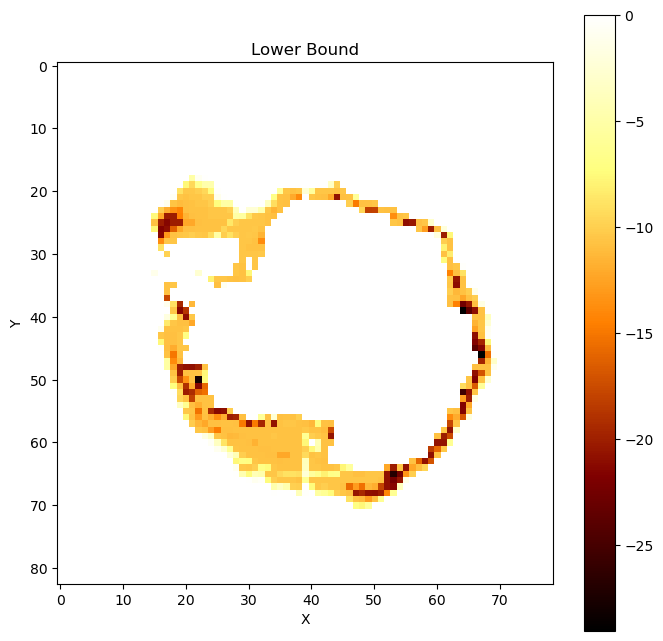

In [8]:


import numpy as np
import glob
import datetime
from datetime import date
from datetime import timedelta
# import datetime
# from dateutil.relativedelta import relativedelta
# from datetime import datetime
# import pandas as pd
import os
from netCDF4 import Dataset
import netCDF4 as nc
import xarray as xr
# from osgeo import gdal
# import geopandas as gpd
# from shapely.geometry import MultiPolygon, Polygon, Point
# from scipy import io
import pandas as pd
from scipy.stats import iqr

new_x= truncating_array_83_79_gpu(kernel_applied_result_in_diff_gray_image_overall)

row, col = 83,79
intial = 15
#for kk in np.arange(1.5, , 0.1):
kk = 1.5
print(kk)

import torch
import torch.nn as nn
import numpy as np

# Assuming new_x is already on GPU
x = torch.tensor(new_x, dtype=torch.float, device=device1)

row, col = 83, 79
initial = 15
kk = 1.5
print(kk)

lower_bound, q1_for_future_use = torch.zeros((row, col), device=device1), torch.zeros((row, col), device=device1)

for i in range(row):
    for j in range(col):
        q1 = torch.quantile(x[:, i, j, :], 0.25)
        q3 = torch.quantile(x[:, i, j, :], 0.75)
        lb = q1 - kk * (q3 - q1)
        lower_bound[i, j] = lb
        q1_for_future_use[i, j] = q1

# Save results
np.savetxt('lb' + str(initial) + '.txt', lower_bound.cpu().numpy(), delimiter='\t', fmt='%.4f')
np.savetxt('q1' + str(initial) + '.txt', q1_for_future_use.cpu().numpy(), delimiter='\t', fmt='%.4f')

initial += 1

# Create a figure and axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Display the 2D matrix as an image
im = ax.imshow(q1_for_future_use.cpu().numpy(), cmap='afmhot')  # You can change the colormap to your preference

# Add a colorbar to the plot (optional)
cbar = fig.colorbar(im, ax=ax)

# Set labels and title (optional)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lower Bound')

# Show the plot
plt.show()



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

device1 = 'cuda'

def pooling(input_matrix, pool_height, pool_width, stride_height, stride_width, pool_type):
    if pool_type == 'max':

        input_matrix1 = torch.tensor(input_matrix, device=device1)  # Move to GPU

        input_matrix2 = torch.where(input_matrix1 > 0, 0, input_matrix1)

        input_matrix3 = torch.abs(input_matrix2)

        input_tensor = torch.tensor(input_matrix3, device=device1)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)

        max_pool = nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=(stride_height, stride_width))

        return_max = max_pool(input_tensor)[0][0].cpu().detach().numpy()
        return -1.0 * return_max

    elif pool_type == 'mean':
        input_tensor = torch.tensor(input_matrix, device=device1)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)

        mean_pool = nn.AvgPool2d(kernel_size=(pool_height, pool_width), stride=(stride_height, stride_width))

        return mean_pool(input_tensor)[0][0].cpu().detach().numpy()

def optimalSolution(matrix, total_std, main_folder, q1, filelist, which_constant, index=0):
    r, c = 2, 2

    filename2 = filelist[index + 1][5:]
    filename1 = filelist[index][5:]

    folder = os.path.join(main_folder, f'{filename2[:-4]}-{filename1[:-4]}')
    if not os.path.exists(folder):
        os.makedirs(folder)

    max_pooled = pooling(matrix, pool_height=r, pool_width=c, stride_height=r, stride_width=c, pool_type='max')
    mean_pooled = pooling(matrix, pool_height=r, pool_width=c, stride_height=r, stride_width=c, pool_type='mean')

    row,col = mean_pooled.shape

    filename_extension = os.path.join(folder, f'{r}x{c}_{which_constant}_{filename2[:-4]}-{filename1[:-4]}')

    saveFile = False
    anomaly_discord_array = torch.zeros(334, 318, device=device1)
    gray_orginal_array = file_to_gray(gray_image_list, index + 1)
    anomaly_discord_all_row_col_list = []

    for i in range(row):
        for j in range(col):
            if max_pooled[i, j] < total_std[i, j]:
                if mean_pooled[i, j] / max_pooled[i, j] > q1[i, j] / total_std[i, j]:
                    getIndices_anomaly = getIndices_in_orginal_gray(i, j,combined_indices_gpu)
                    anomaly_discord_all_row_col_list.append(getIndices_anomaly)
                    saveFile = True

    for iii in range(len(anomaly_discord_all_row_col_list)):
        iterativeList = anomaly_discord_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            anomaly_discord_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    anomaly_discord_array = anomaly_discord_array[1:-1, 1:-1]
    np.savetxt(f'{filename_extension}_anomaly_discord.txt', anomaly_discord_array.cpu().numpy(), delimiter='\t', fmt='%d')

    saveFile = False
    hh_array = torch.zeros(334, 318, device=device1)
    hh_all_row_col_list = []
    counter = 0

    for i in range(row):
        for j in range(col):
            if max_pooled[i, j] < total_std[i, j]:
                if 0 < mean_pooled[i, j] / max_pooled[i, j] < q1[i, j] / total_std[i, j]:
                    counter += 1
                    getIndices_hh = getIndices_in_orginal_gray(i, j,combined_indices_gpu)
                    hh_all_row_col_list.append(getIndices_hh)
                    saveFile = True

    for iii in range(len(hh_all_row_col_list)):
        iterativeList = hh_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            hh_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    hh_array = hh_array[1:-1, 1:-1]
    np.savetxt(f'{filename_extension}_hh.txt', hh_array.cpu().numpy(), delimiter='\t', fmt='%d')

    saveFile = False
    ss_array = torch.zeros(334, 318, device=device1)
    ss_all_row_col_list = []
    counter = 0

    for i in range(row):
        for j in range(col):
            if 0 < mean_pooled[i, j] < q1[i, j]:
                counter += 1
                getIndices_ss = getIndices_in_orginal_gray(i, j,combined_indices_gpu)
                ss_all_row_col_list.append(getIndices_ss)
                saveFile = True

    for iii in range(len(ss_all_row_col_list)):
        iterativeList = ss_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            ss_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    ss_array = ss_array[1:-1, 1:-1]
    np.savetxt(f'{filename_extension}_ss.txt', ss_array.cpu().numpy(), delimiter='\t', fmt='%d')


In [10]:






iterator = 0


for year in range(2000,2023):
    filelist = glob.glob(str(year)+'/*.png')
    filelist.sort()

    print(filelist)


    gray_image_list,rgb_image_list = rgb_to_gray_image_conversion_gpu(filelist)
    diff_gray_image_list, diff_gray_image_kernel_list_2_2 = get_diff_gray_image_kernel_list_gpu(gray_image_list)

    folder_holder = 'anomaly_discord_and_ss_with_IQR_'+str(year)
                        
    if not os.path.exists(folder_holder):
        print('I am here')
        os.makedirs(folder_holder)


    kernel_applied_result_in_diff_gray_image = get_kernel_applied_result_in_diff_gray_image_gpu(diff_gray_image_list,diff_gray_image_kernel_list_2_2)

    #print('shape of the kernel_applied')
    #print(np.array(kernel_applied_result_in_diff_gray_image).shape)

    #total_std,q1 = calculateIQR(kernel_applied_result_in_diff_gray_image)
    
    for i in range(len(kernel_applied_result_in_diff_gray_image)):                    
                
        matrix = kernel_applied_result_in_diff_gray_image[i]



        for kkkk in range(15,16,1):
            
            total_std = np.loadtxt('lb'+str(kkkk)+'.txt')
            q1 = np.loadtxt('q1'+str(kkkk)+'.txt')
            
            optimalSolution(matrix,total_std,folder_holder,q1,filelist,kkkk,i)
    

    





print('we are complete',iterator)
   

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


# max pool shape
# (83, 79)

['2000/20000901.png', '2000/20000902.png', '2000/20000903.png', '2000/20000904.png', '2000/20000905.png', '2000/20000906.png', '2000/20000907.png', '2000/20000908.png', '2000/20000909.png', '2000/20000910.png', '2000/20000911.png', '2000/20000912.png', '2000/20000913.png', '2000/20000914.png', '2000/20000915.png', '2000/20000916.png', '2000/20000917.png', '2000/20000918.png', '2000/20000919.png', '2000/20000920.png', '2000/20000921.png', '2000/20000922.png', '2000/20000923.png', '2000/20000924.png', '2000/20000925.png', '2000/20000926.png', '2000/20000927.png', '2000/20000928.png', '2000/20000929.png', '2000/20000930.png', '2000/20001001.png', '2000/20001002.png', '2000/20001003.png', '2000/20001004.png', '2000/20001005.png', '2000/20001006.png', '2000/20001007.png', '2000/20001008.png', '2000/20001009.png', '2000/20001010.png', '2000/20001011.png', '2000/20001012.png', '2000/20001013.png', '2000/20001014.png', '2000/20001015.png', '2000/20001016.png', '2000/20001017.png', '2000/200010

/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_17444/1533440381.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr_gpu = (torch.tensor(gray_image_list[i+1], dtype=torch.float, device=device1).clone().detach() - torch.tensor(gray_image_list[i], dtype=torch.float, device=device1).clone().detach())
/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_17444/465422505.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_matrix3, device=device1)
/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_17444/465422505.py:58: RuntimeWarning: invalid value encountered in scalar divide
  if mean_pooled[i, j] / max_pooled[i, j] > q1[i, j] /

['2001/20010901.png', '2001/20010902.png', '2001/20010903.png', '2001/20010904.png', '2001/20010905.png', '2001/20010906.png', '2001/20010907.png', '2001/20010908.png', '2001/20010909.png', '2001/20010910.png', '2001/20010911.png', '2001/20010912.png', '2001/20010913.png', '2001/20010914.png', '2001/20010915.png', '2001/20010916.png', '2001/20010917.png', '2001/20010918.png', '2001/20010919.png', '2001/20010920.png', '2001/20010921.png', '2001/20010922.png', '2001/20010923.png', '2001/20010924.png', '2001/20010925.png', '2001/20010926.png', '2001/20010927.png', '2001/20010928.png', '2001/20010929.png', '2001/20010930.png', '2001/20011001.png', '2001/20011002.png', '2001/20011003.png', '2001/20011004.png', '2001/20011005.png', '2001/20011006.png', '2001/20011007.png', '2001/20011008.png', '2001/20011009.png', '2001/20011010.png', '2001/20011011.png', '2001/20011012.png', '2001/20011013.png', '2001/20011014.png', '2001/20011015.png', '2001/20011016.png', '2001/20011017.png', '2001/200110

In [11]:
# import numpy as np

# # Sample padded array (334x318)
# padded_array = np.random.randint(0, 10, (334, 318))  # Creating a random array for demonstration purposes

# print("Padded array shape:", padded_array.shape)
# print(padded_array)

# # Removing the padding by indexing
# unpadded_array = padded_array[1:-1, 1:-1]

# print("Unpadded array shape:", unpadded_array.shape)
# print(unpadded_array)



In [12]:
# import torch
# import torch.nn as nn
# import numpy as np


# new_x = truncating_array_83_79_gpu(kernel_applied_result_in_diff_gray_image_overall)

# row, col = 83, 79
# initial = 15
# kk = 1.5
# print(kk)

# x = torch.tensor(new_x, dtype=torch.float, device='mps')


# lower_bound, q1_for_future_use = torch.zeros((row, col)), torch.zeros((row, col), device='mps')

# for i in range(row):
#     for j in range(col):
#         q1 = torch.quantile(x[:, i, j, :], 0.25)

#         q3 = torch.quantile(x[:, i, j, :],0.75)

#         lb = q1 - kk * (q3-q1)
#         lower_bound[i, j] = lb
#         q1_for_future_use[i, j] = q1

# np.savetxt('lb' + str(initial) + '_gpu.txt', lower_bound.cpu().numpy(), delimiter='\t', fmt='%.4f')
# np.savetxt('q1' + str(initial) + '_gpu.txt', q1_for_future_use.cpu().numpy(), delimiter='\t', fmt='%.4f')

# initial += 1

# # Create a figure and axis
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8, 8))

# # Display the 2D matrix as an image
# im = ax.imshow(q1_for_future_use.cpu().numpy(), cmap='afmhot')  # You can change the colormap to your preference

# # Add a colorbar to the plot (optional)
# cbar = fig.colorbar(im, ax=ax)

# # Set labels and title (optional)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Lower Bound')

# # Show the plot
# plt.show()
